In [1]:
! pip install keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras.optimizers import gradient_descent_v2
sgd = gradient_descent_v2.SGD(...)
%matplotlib inline

2022-04-18 14:15:29.293062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-18 14:15:29.293087: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
num_imgs = 50000

img_size = 16
min_rect_size = 3
max_rect_size = 8
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))
shapes = np.zeros((num_imgs, num_objects, 1))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        if np.random.choice([True, False]):
            width, height = np.random.randint(min_rect_size, max_rect_size, size=2)
            x = np.random.randint(0, img_size - width)
            y = np.random.randint(0, img_size - height)
            imgs[i_img, x:x+width, y:y+height] = 1.
            bboxes[i_img, i_object] = [x, y, width, height]
            shapes[i_img, i_object] = [0]
        else:
            size = np.random.randint(min_rect_size, max_rect_size)
            x, y = np.random.randint(0, img_size - size, size=2)
            mask = np.tril_indices(size)
            imgs[i_img, x + mask[0], y + mask[1]] = 1.
            bboxes[i_img, i_object] = [x, y, size, size]
            shapes[i_img, i_object] = [1]
            
imgs.shape, bboxes.shape

((50000, 16, 16), (50000, 2, 4))

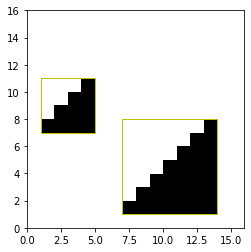

In [3]:
i = 0
# TODO: Why does the array have to be transposed?
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox, shape in zip(bboxes[i], shapes[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r' if shape[0] == 0 else 'y', fc='none'))

In [4]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 256), -5.892397680895556e-17, 1.0000000000000004)

In [5]:
y = np.concatenate([bboxes / img_size, shapes], axis=-1).reshape(num_imgs, -1)
y.shape

(50000, 10)

In [6]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
# from keras.optimizers import SGD
model = Sequential([
        Dense(256, input_dim=X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.4), 
        Dense(y.shape[-1])
    ])
model.compile('adadelta', 'mse')

2022-04-18 14:15:36.520739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 14:15:36.521085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-18 14:15:36.521130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-18 14:15:36.521164: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-18 14:15:36.521198: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [8]:
# Flip bboxes during training.
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

def dist(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

num_epochs_flipping = 500
num_epochs_no_flipping = 0  # has no significant effect
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))
ious_epoch = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))
dists_epoch = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))
mses_epoch = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))

# TODO: Calculate ious directly for all samples (using slices of the array pred_y for x, y, w, h).
for epoch in range(num_epochs_flipping):
    print('Epoch', epoch)
    model.fit(train_X, flipped_train_y, epochs=1, validation_data=(test_X, test_y), verbose=2)
    pred_y = model.predict(train_X)

    for sample, (pred, exp) in enumerate(zip(pred_y, flipped_train_y)):
        
        # TODO: Make this simpler.
        pred = pred.reshape(num_objects, -1)
        exp = exp.reshape(num_objects, -1)
        
        pred_bboxes = pred[:, :4]
        exp_bboxes = exp[:, :4]
        
        # TODO: Try flipping array and see if results differ.
        ious = np.zeros((num_objects, num_objects))
        dists = np.zeros((num_objects, num_objects))
        mses = np.zeros((num_objects, num_objects))
        for i, exp_bbox in enumerate(exp_bboxes):
            for j, pred_bbox in enumerate(pred_bboxes):
                ious[i, j] = IOU(exp_bbox, pred_bbox)
                dists[i, j] = dist(exp_bbox, pred_bbox)
                mses[i, j] = np.mean(np.square(exp_bbox - pred_bbox))
                
        new_order = np.zeros(num_objects, dtype=int)
        
        for i in range(num_objects):
            # Find pred and exp bbox with maximum iou and assign them to each other (i.e. switch the positions of the exp bboxes in y).
            ind_exp_bbox, ind_pred_bbox = np.unravel_index(mses.argmin(), mses.shape)
            ious_epoch[sample, epoch] += ious[ind_exp_bbox, ind_pred_bbox]
            dists_epoch[sample, epoch] += dists[ind_exp_bbox, ind_pred_bbox]
            mses_epoch[sample, epoch] += mses[ind_exp_bbox, ind_pred_bbox]
            mses[ind_exp_bbox] = 1000000#-1  # set iou of assigned bboxes to -1, so they don't get assigned again
            mses[:, ind_pred_bbox] = 10000000#-1
            new_order[ind_pred_bbox] = ind_exp_bbox
        
        flipped_train_y[sample] = exp[new_order].flatten()
        
        flipped[sample, epoch] = 1. - np.mean(new_order == np.arange(num_objects, dtype=int))#np.array_equal(new_order, np.arange(num_objects, dtype=int))  # TODO: Change this to reflect the number of flips.
        ious_epoch[sample, epoch] /= num_objects
        dists_epoch[sample, epoch] /= num_objects
        mses_epoch[sample, epoch] /= num_objects
        
            
    print ('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print ('Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch])))
    print ('Mean dist: {}'.format(np.mean(dists_epoch[:, epoch])))
    print ('Mean mse: {}'.format(np.mean(mses_epoch[:, epoch])))
    print
    
# print '------------------------------------'
# print 'Training now without flipping bboxes'
# print '------------------------------------'
    
# for epoch in range(num_epochs_flipping, num_epochs_flipping + num_epochs_no_flipping):
#     print 'Epoch', epoch
#     model.fit(train_X, flipped_train_y, nb_epoch=1, validation_data=(test_X, test_y), verbose=2)
#     pred_y = model.predict(train_X)

#     # Calculate iou/dist, but don't flip.
#     for sample, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
#         pred_bboxes = pred_bboxes.reshape(num_objects, -1)
#         exp_bboxes = exp_bboxes.reshape(num_objects, -1)        
        
#         for exp_bbox, pred_bbox in zip(exp_bboxes, pred_bboxes):
#             ious_epoch[sample, epoch] += IOU(exp_bbox, pred_bbox)
#             dists_epoch[sample, epoch] += dist(exp_bbox, pred_bbox)
#             mses_epoch[sample, epoch] += np.mean(np.square(exp_bbox - pred_bbox))
            
#         ious_epoch[sample, epoch] /= num_objects
#         dists_epoch[sample, epoch] /= num_objects 
#         mses_epoch[sample, epoch] /= num_objects 
            
# #     print 'Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.)
#     print 'Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch]))
#     print 'Mean dist: {}'.format(np.mean(dists_epoch[:, epoch]))
#     print 'Mean mse: {}'.format(np.mean(mses_epoch[:, epoch]))
#     print
    
# TODO: Calculate IOU and dist for validation data during training.

Epoch 0
1250/1250 - 1s - loss: 1.3721 - val_loss: 0.6726 - 1s/epoch - 963us/step
Flipped 49.2525 % of all elements
Mean IOU: 0.008471305254443106
Mean dist: 0.9091837080502011
Mean mse: 0.5046763555327691
Epoch 1
1250/1250 - 1s - loss: 1.1176 - val_loss: 0.5303 - 967ms/epoch - 774us/step
Flipped 7.327500000000001 % of all elements
Mean IOU: 0.011399815721083714
Mean dist: 0.8242436707482308
Mean mse: 0.4186213397753919
Epoch 2
1250/1250 - 1s - loss: 0.9826 - val_loss: 0.4499 - 915ms/epoch - 732us/step
Flipped 5.609999999999999 % of all elements
Mean IOU: 0.013708799800145033
Mean dist: 0.7627006670339251
Mean mse: 0.3623948231216069
Epoch 3
1250/1250 - 1s - loss: 0.8904 - val_loss: 0.3986 - 841ms/epoch - 673us/step
Flipped 4.6274999999999995 % of all elements
Mean IOU: 0.01601432357732551
Mean dist: 0.7144656251595125
Mean mse: 0.32123552277965045
Epoch 4
1250/1250 - 1s - loss: 0.8221 - val_loss: 0.3618 - 1s/epoch - 807us/step
Flipped 3.6275000000000004 % of all elements
Mean IOU: 0.01

KeyboardInterrupt: 

Text(0, 0.5, 'Training sample')

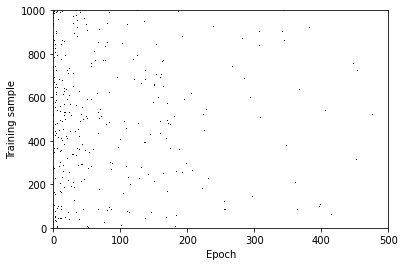

In [ ]:
plt.pcolor(flipped[:1000], cmap='Greys', vmax=1.)
# plt.axvline(num_epochs_flipping, c='r')
plt.xlabel('Epoch')
plt.ylabel('Training sample')

(0.0, 1.0)

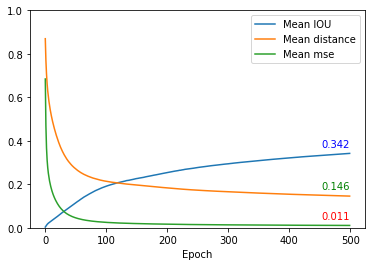

In [ ]:
mean_ious_epoch = np.mean(ious_epoch, axis=0)
mean_dists_epoch = np.mean(dists_epoch, axis=0)
mean_mses_epoch = np.mean(mses_epoch, axis=0)
plt.plot(mean_ious_epoch, label='Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label='Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label='Mean mse')  # relative to image size
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch)-1, mean_ious_epoch[-1]+0.03), horizontalalignment='right', color='b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch)-1, mean_dists_epoch[-1]+0.03), horizontalalignment='right', color='g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch)-1, mean_mses_epoch[-1]+0.03), horizontalalignment='right', color='r')
# plt.axvline(num_epochs_flipping, c='r')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 1)

# plt.savefig('plots/bw-multiple-rectangles-mse.png', dpi=300)

In [ ]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = pred_y[..., 4:5]
pred_bboxes.shape, pred_shapes.shape

((10000, 2, 4), (10000, 2, 1))

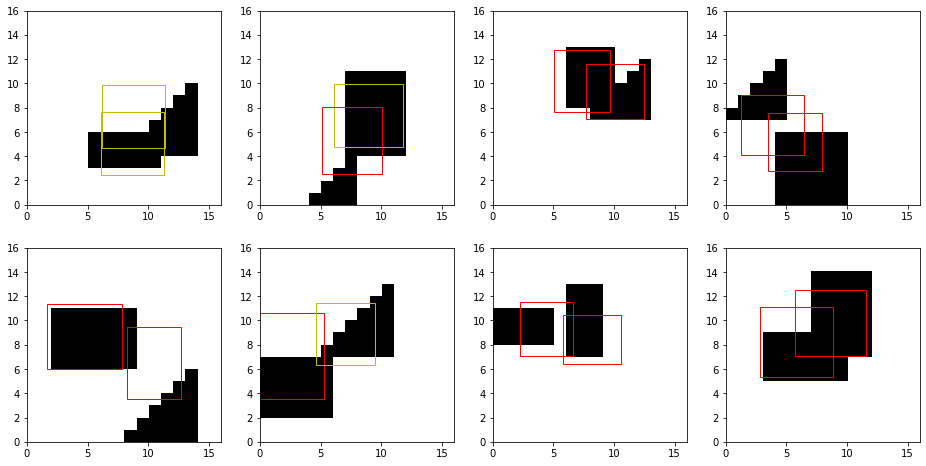

In [ ]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 9):
    plt.subplot(2, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox, pred_shape in zip(pred_bboxes[i], test_bboxes[i], pred_shapes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r' if pred_shape[0] <= 0.5 else 'y', fc='none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
#         plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')